In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2021-12-12 21:11:46.437367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-12 21:11:46.437387: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


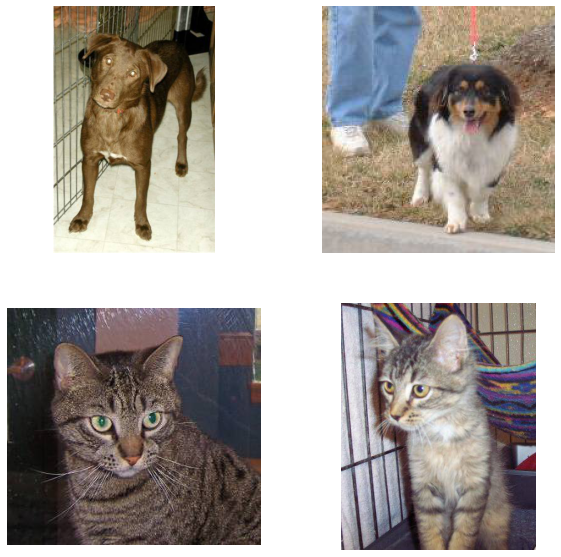

In [2]:
# examples of image visualisation
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
_ = axs[0, 0].imshow(PIL.Image.open('data/train/dog.1.jpg'))
_ = axs[0, 0].axis('off')

_ = axs[0, 1].imshow(PIL.Image.open('data/train/dog.2.jpg'))
_ = axs[0, 1].axis('off')

_ = axs[1, 0].imshow(PIL.Image.open('data/train/cat.1.jpg'))
_ = axs[1, 0].axis('off')

_ = axs[1, 1].imshow(PIL.Image.open('data/train/cat.2.jpg'))
_ = axs[1, 1].axis('off')

In [3]:
# create a train/test df, containing the image filepaths and training label
import os
 
def list_full_paths(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory)]

train = pd.DataFrame({'filepath': list_full_paths('data/train/')})
train['truth_label'] = np.where(train['filepath'].str.contains('dog'), 'dog', 'cat')

test = pd.DataFrame({'filepath': list_full_paths('data/test/')})

In [4]:
train.head(20)

,filepath,truth_label
0,data/train/dog.3108.jpg,dog
1,data/train/dog.3331.jpg,dog
2,data/train/dog.1824.jpg,dog
3,data/train/dog.11268.jpg,dog
4,data/train/cat.7165.jpg,cat
5,data/train/cat.2104.jpg,cat
6,data/train/cat.1796.jpg,cat
7,data/train/cat.10696.jpg,cat
8,data/train/cat.2622.jpg,cat
9,data/train/cat.5082.jpg,cat


In [5]:
test.head()

,filepath
0,data/test/2682.jpg
1,data/test/9254.jpg
2,data/test/2771.jpg
3,data/test/6778.jpg
4,data/test/1993.jpg


In [6]:
# split train into train and validation, ensuring reproducability
from sklearn.model_selection import train_test_split
train, validation = train_test_split(train, test_size=0.2, random_state=1, shuffle=True)

In [7]:
#train.head(10)
#validation.head(10)
print(np.sum(train['truth_label'] == 'cat') / len(train))
print(np.sum(train['truth_label'] == 'dog') / len(train))

print(np.sum(validation['truth_label'] == 'cat') / len(validation))
print(np.sum(validation['truth_label'] == 'dog') / len(validation))

# roughly even splitting, no need for reweighting/resampling

0.50235
0.49765
0.4906
0.5094


In [13]:
# data pre-processing
train_gen = ImageDataGenerator(rescale=1. / 255)
val_gen = ImageDataGenerator(rescale=1. / 255)

train_generator      = train_gen.flow_from_dataframe(dataframe=train, x_col='filepath', y_col='truth_label', class_mode='categorical')
validation_generator = val_gen.flow_from_dataframe(dataframe=validation, x_col='filepath', y_col='truth_label', class_mode='categorical')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
(20000, 2)


# TODO data augmentation
* Random flips/rotatations
* Random zooms
* Colour scaling/reversing?

In [16]:
# model definition
model = Sequential()

input_shape = (255, 255, 3)

model.add(Conv2D(input_shape=input_shape, filters=32, kernel_size=(4, 4), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())

model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 252, 252, 32)      1568      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 508032)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5080330   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 22        
Total params: 5,081,920
Trainable params: 5,081,920
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit data
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# callbacks
es = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min', restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='min', min_lr=0.00000001)

epochs = 50
history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=[es, lr])

Epoch 1/50


2021-12-12 21:18:24.985879: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 262180864 exceeds 10% of free system memory.
2021-12-12 21:18:25.132738: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 262180864 exceeds 10% of free system memory.


  1/625 [..............................] - ETA: 8:13 - loss: 0.6687 - accuracy: 0.5938

2021-12-12 21:18:25.437755: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 262180864 exceeds 10% of free system memory.
2021-12-12 21:18:25.560855: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 262180864 exceeds 10% of free system memory.


625/625 [==============================] - 359s 574ms/step - loss: 0.7337 - accuracy: 0.4961 - val_loss: 0.6933 - val_accuracy: 0.4906
Epoch 2/50
625/625 [==============================] - 361s 577ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6935 - val_accuracy: 0.4906
Epoch 3/50
625/625 [==============================] - 348s 557ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6932 - val_accuracy: 0.4906
Epoch 4/50
625/625 [==============================] - 342s 547ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.5094
Epoch 5/50
221/625 [=========>....................] - ETA: 3:31 - loss: 0.6932 - accuracy: 0.5031

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
_ = axs[0].plot(history.history['loss'], label='Test')
_ = axs[0].plot(history.history['val_loss'], label='Validation')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
_ = axs[0].legend()

_ = axs[1].plot(history.history['accuracy'], label='Test')
_ = axs[1].plot(history.history['val_accuracy'], label='Validation')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
_ = axs[1].legend()

In [ ]:
# pred on validation, submit predictions to kaggle
y_pred = np.argmax(model.predict(X_test), axis=1)
from sklearn.metrics import ConfusionMatrixDisplay
_ = ConfusionMatrixDisplay.from_predictions(test.class_protein_localization.values, y_pred, normalize='true')